# Disney Recommendation Mini-Project
For this project, we will be exploring a dataset containing Disney+ titles and relevant details. The goal of this mini-project is to build a simple recommendation model to give related/recommended titles based on an input of movie titles.

The dataset we will be exploring can be found here:
https://www.kaggle.com/datasets/shivamb/disney-movies-and-tv-shows

### Import and explore data

In [1]:
# dependencies 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("disney_plus_titles.csv")
df.head(10)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Duck the Halls: A Mickey Mouse Christmas Special,"Alonso Ramirez Ramos, Dave Wasson","Chris Diamantopoulos, Tony Anselmo, Tress MacN...",NaN,11/26/2021,2016,TV-G,23 min,"Animation, Family",Join Mickey and the gang as they duck the halls!
1,s2,Movie,Ernest Saves Christmas,John Cherry,"Jim Varney, Noelle Parker, Douglas Seale",NaN,11/26/2021,1988,PG,91 min,Comedy,Santa Claus passes his magic bag to a new St. ...
2,s3,Movie,Ice Age: A Mammoth Christmas,Karen Disher,"Raymond Albert Romano, John Leguizamo, Denis L...",United States,11/26/2021,2011,TV-G,23 min,"Animation, Comedy, Family",Sid the Sloth is on Santa's naughty list.
3,s4,Movie,The Queen Family Singalong,Hamish Hamilton,"Darren Criss, Adam Lambert, Derek Hough, Alexa...",NaN,11/26/2021,2021,TV-PG,41 min,Musical,"This is real life, not just fantasy!"
4,s5,TV Show,The Beatles: Get Back,NaN,"John Lennon, Paul McCartney, George Harrison, ...",NaN,11/25/2021,2021,NaN,1 Season,"Docuseries, Historical, Music",A three-part documentary from Peter Jackson ca...
5,s6,Movie,Becoming Cousteau,Liz Garbus,"Jacques Yves Cousteau, Vincent Cassel",United States,11/24/2021,2021,PG-13,94 min,"Biographical, Documentary",An inside look at the legendary life of advent...
6,s7,TV Show,Hawkeye,NaN,"Jeremy Renner, Hailee Steinfeld, Vera Farmiga,...",NaN,11/24/2021,2021,TV-14,1 Season,"Action-Adventure, Superhero",Clint Barton/Hawkeye must team up with skilled...
7,s8,TV Show,Port Protection Alaska,NaN,"Gary Muehlberger, Mary Miller, Curly Leach, Sa...",United States,11/24/2021,2015,TV-14,2 Seasons,"Docuseries, Reality, Survival",Residents of Port Protection must combat volat...
8,s9,TV Show,Secrets of the Zoo: Tampa,NaN,"Dr. Ray Ball, Dr. Lauren Smith, Chris Massaro,...",United States,11/24/2021,2019,TV-PG,2 Seasons,"Animals & Nature, Docuseries, Family",A day in the life at ZooTampa is anything but ...
9,s10,Movie,A Muppets Christmas: Letters To Santa,Kirk R. Thatcher,"Steve Whitmire, Dave Goelz, Bill Barretta, Eri...",United States,11/19/2021,2008,G,45 min,"Comedy, Family, Musical",Celebrate the holiday season with all your fav...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       1450 non-null   object
 1   type          1450 non-null   object
 2   title         1450 non-null   object
 3   director      977 non-null    object
 4   cast          1260 non-null   object
 5   country       1231 non-null   object
 6   date_added    1447 non-null   object
 7   release_year  1450 non-null   int64 
 8   rating        1447 non-null   object
 9   duration      1450 non-null   object
 10  listed_in     1450 non-null   object
 11  description   1450 non-null   object
dtypes: int64(1), object(11)
memory usage: 136.1+ KB


We can see all the attributes displayed for each movie. We can also see that there are significant missing values in 'director', 'cast', and 'country', as well as a few missing from 'date_added' and 'rating'. To confirm:

In [4]:
df.isna().sum()

show_id           0
type              0
title             0
director        473
cast            190
country         219
date_added        3
release_year      0
rating            3
duration          0
listed_in         0
description       0
dtype: int64

The information here could be useful, so it's better not to drop it unless there's no valid replacement. For unknown country values, we'll just use a blank string ('') as a placeholder. For the rating and date added, we can just use the most common value (the mode) of the data as a replacement. Finally, cast and director can't be filled in with a blank or random value, so we'll drop the missing ones from those columns instead.

Note: There is a special case for missing director - many TV shows in the list have no listed director (possibly due to TV shows usually only having a producer, instead of a director). Removing all of these values would make the dataset purely *movies*, so we'll replace the missing values in this case to a special note.

In [5]:
df['country'] = df['country'].fillna('Unlisted')
df['rating'] = df['rating'].fillna(df.rating.mode()[0])
df['date_added'] = df['date_added'].fillna(df['date_added'].mode()[0])

for index in df.index:
    if df.type[index] == 'TV Show':
        df.director[index] = 'No Director: TV Show'
df.dropna(inplace=True)
df.isna().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

## Initial Data Exploration
Before we go on to building a recommender, let's take a look at some trends in the data. Some interesting features to explore trends in include (but are not limited to) country, release_year, duration, rating, and type. We will quickly look into these features to see what kind of distributions we can find.

### Production Country
Exploring the top production countries for the films/shows available in the dataset.

In [6]:
df.country.value_counts()

United States                                                  854
Unlisted                                                       134
United States, Canada                                           29
United States, United Kingdom                                   22
United Kingdom                                                  20
                                                              ... 
Ireland, United States                                           1
Ireland, United Kingdom, United States, South Korea, Canada      1
United States, South Korea, France                               1
United States, Australia, France, Canada                         1
United States, Ireland                                           1
Name: country, Length: 88, dtype: int64

There are actually many entries with several countries listed. However, the order does matter so for the sake of analyzing the data, we'll just look at the FIRST listed country, as the main country of production.

In [7]:
df['main_country'] = df['country'].apply(lambda x: x.split(",")[0])
df.main_country.value_counts()

United States           968
Unlisted                134
United Kingdom           47
Canada                   26
France                   10
Australia                 4
Ireland                   3
Argentina                 3
Germany                   2
China                     2
Austria                   2
United Arab Emirates      1
Tanzania                  1
Denmark                   1
Norway                    1
South Korea               1
New Zealand               1
Name: main_country, dtype: int64

A much cleaner country list, with a blank entry for unlisted production country. Visualizing:

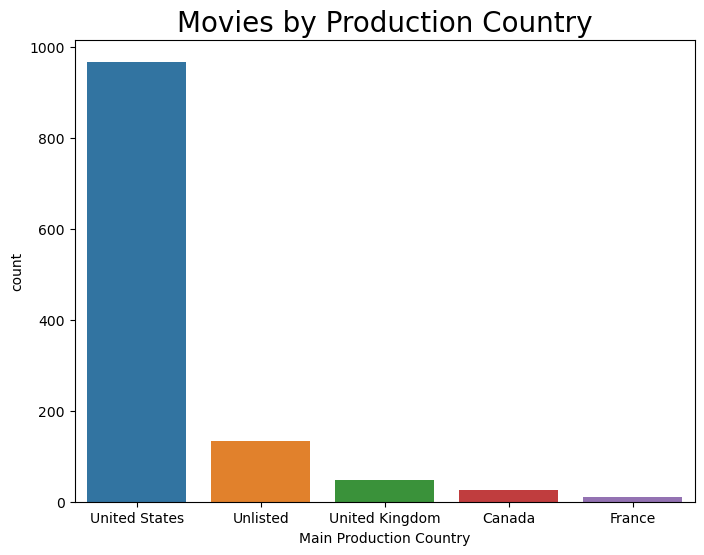

In [8]:
plt.figure(figsize=(8,6))
sns.countplot(x="main_country", data= df, order=df['main_country'].value_counts().index[0:5])
plt.xlabel('Main Production Country')
plt.title('Movies by Production Country', size=20);

### Release Year
Exploring the release year distribution in the dataset.

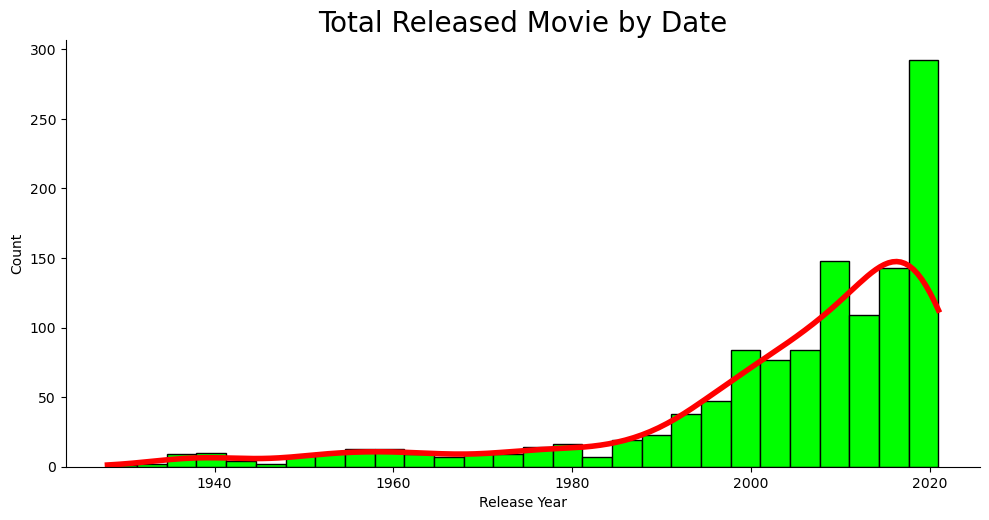

In [9]:
sns.displot(data=df, x='release_year', kind='hist', kde=True, color='r', facecolor='lime', edgecolor='black',
            line_kws={'lw': 4}, aspect=2)
plt.xlabel('Release Year')
plt.title('Total Released Movie by Date', size=20);

It is clear that more newly released movies/shows are more common, with 2020 being the top addition year.

### Duration
Exploring the distribution of movie and show durations.

In [10]:
df.duration.value_counts()

1 Season     162
2 Seasons     73
3 Seasons     44
94 min        27
88 min        26
            ... 
32 min         1
33 min         1
31 min         1
8 Seasons      1
13 min         1
Name: duration, Length: 152, dtype: int64

There is a unique problem here where some values are in 'seasons' (TV shows), while others are in 'min' (movies). Both are meaningful to explore, so let's temporarily split the data between the two for analysis.

In [11]:
movies=df.loc[df.duration.str.contains("min")]
movies.duration = movies.duration.str.replace(' min', '') 
movies.duration = movies.duration.astype(str).astype(int)

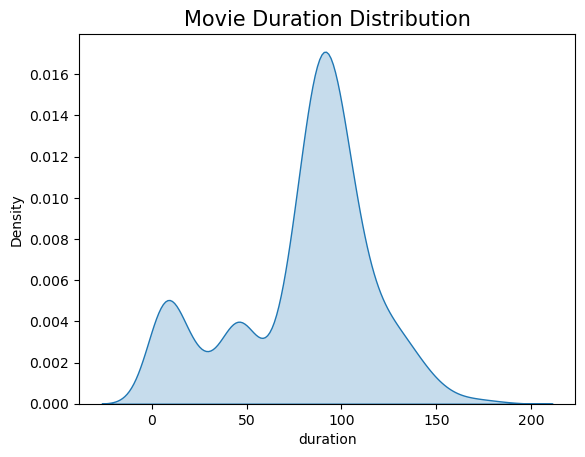

In [12]:
sns.kdeplot(data=movies, x='duration' , shade=True)
plt.title('Movie Duration Distribution', size=15);

Here, we can see most movies are within the 80-120min range. Let's see what the TV show seasons look like as well.

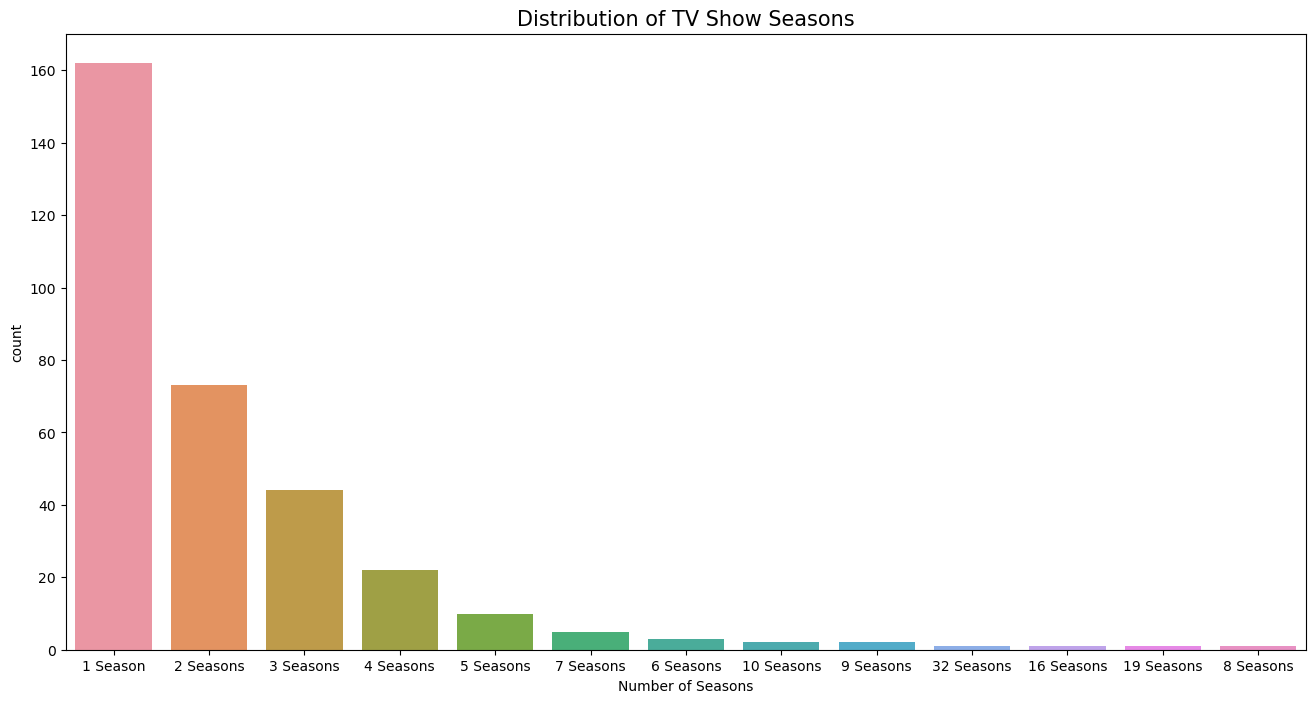

In [13]:
tv=df.loc[df.type == 'TV Show']
plt.figure(figsize=(16,8))
sns.countplot(x="duration", data=tv, order=tv['duration'].value_counts().index[0:15])
plt.title('Distribution of TV Show Seasons', size=15)
plt.xlabel('Number of Seasons');

As we can see, most shows end within the first 5 seasons, with a few extreme cases (32 seasons!!!).

### Rating
Exploring the different ratings of available TV shows and movies. Keep in mind that this is the film rating (G, PG13, etc.), not the review rating.

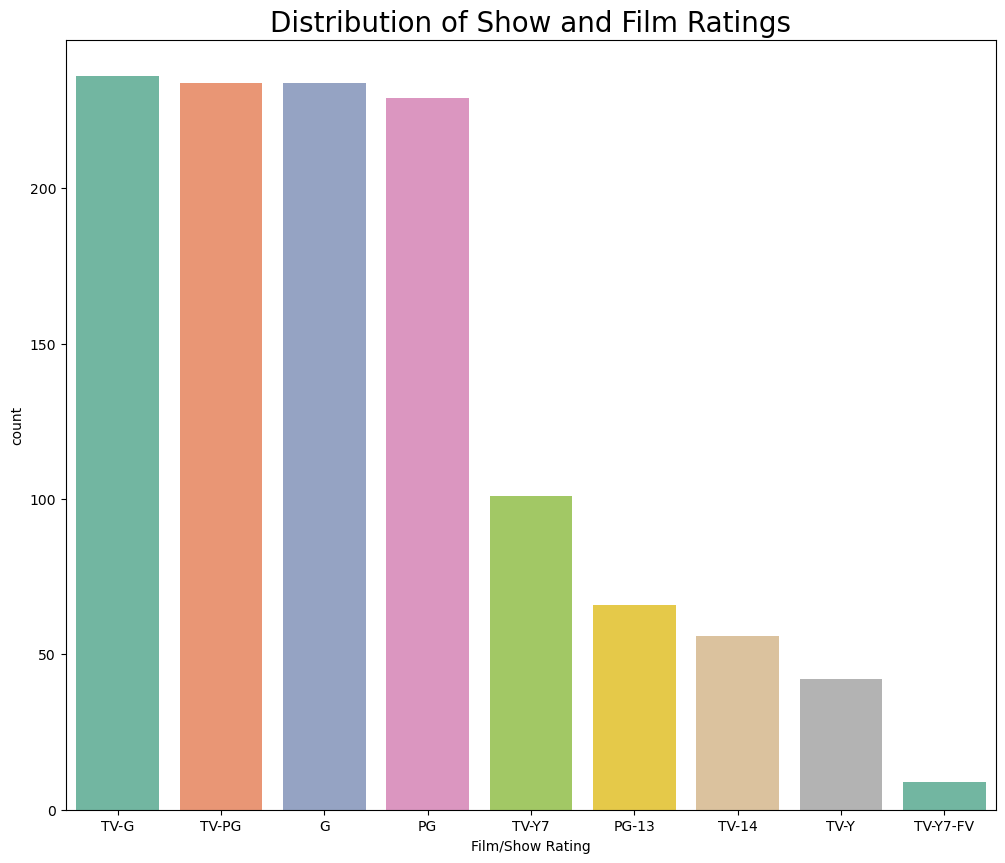

In [14]:
plt.figure(figsize=(12,10))
sns.countplot(x="rating", data= df, palette="Set2", order=df['rating'].value_counts().index[0:15])
plt.xlabel('Film/Show Rating')
plt.title('Distribution of Show and Film Ratings', size=20);

Here we can see that most films and shows are rated for younger or general audiences, as expected. TV-G, TV-PG, G, and PG dominate the ratings. Note: TV-G and G are different in that TV-G is a TV series rating and G is a film rating.

### Type
Finally, we'll explore the type of media. This has been already mentioned (TV shows and movies), but it'd still be nice to see how the data is split.

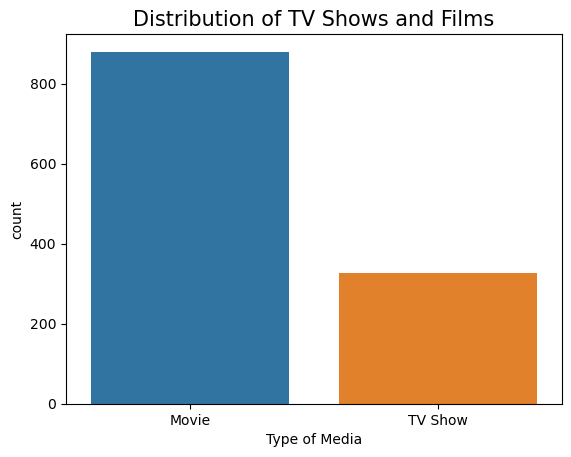

In [15]:
ax = sns.countplot(x="type", data=df)
ax.bar_label(ax.containers[0])
plt.xlabel('Type of Media')
plt.title('Distribution of TV Shows and Films', size=15);

There are over twice as many movies as there are TV Shows! 

Now that we've gone over the distributions of features in this dataset, let's finally get to making a recommendation system for the TV shows and movies in the Disney+ dataset!

# Recommendation
The goal of this mini-project is to build a simple recommendation system, where selected movie/TV show titles will return recommended similar titles. We don't have ratings in this dataset, so hybrid or collaborative systems are out of the question. We will instead use a (mostly) content based system. We therefore need to choose some relevant features to predict based on similar content.

In [18]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,main_country
0,s1,Movie,Duck the Halls: A Mickey Mouse Christmas Special,"Alonso Ramirez Ramos, Dave Wasson","Chris Diamantopoulos, Tony Anselmo, Tress MacN...",Unlisted,11/26/2021,2016,TV-G,23 min,"Animation, Family",Join Mickey and the gang as they duck the halls!,Unlisted
1,s2,Movie,Ernest Saves Christmas,John Cherry,"Jim Varney, Noelle Parker, Douglas Seale",Unlisted,11/26/2021,1988,PG,91 min,Comedy,Santa Claus passes his magic bag to a new St. ...,Unlisted
2,s3,Movie,Ice Age: A Mammoth Christmas,Karen Disher,"Raymond Albert Romano, John Leguizamo, Denis L...",United States,11/26/2021,2011,TV-G,23 min,"Animation, Comedy, Family",Sid the Sloth is on Santa's naughty list.,United States
3,s4,Movie,The Queen Family Singalong,Hamish Hamilton,"Darren Criss, Adam Lambert, Derek Hough, Alexa...",Unlisted,11/26/2021,2021,TV-PG,41 min,Musical,"This is real life, not just fantasy!",Unlisted
4,s5,TV Show,The Beatles: Get Back,No Director: TV Show,"John Lennon, Paul McCartney, George Harrison, ...",Unlisted,11/25/2021,2021,TV-G,1 Season,"Docuseries, Historical, Music",A three-part documentary from Peter Jackson ca...,Unlisted


<u>The metrics we will use for this recommender are:</u>
 - Title
 - Cast
 - listed_in (a.k.a genre)
 - Description

Many of these values are descriptions or lists of names/genres. We need to clean this data and create a 'bag of words' or word 'soup' to be used in the recommender.

## Clean and reformat data
Remove spaces and capitalization for each feature and recreate the dataframe. We'll keep the title in the features dataframe to preserve readability later on after recommendation is done. This acts as an index for our data, but we don't necessarily have to use it in the recommendation itself.

In [259]:
# define features
features = ['title', 'cast', 'listed_in', 'description']

# new dataframe for feature data
feature_df = df[features]
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1207 entries, 0 to 1449
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        1207 non-null   object
 1   cast         1207 non-null   object
 2   listed_in    1207 non-null   object
 3   description  1207 non-null   object
dtypes: object(4)
memory usage: 79.4+ KB


### 1. Clean the data
Remove spaces and capitalization. We will write a small function to help with this.

In [260]:
# remove spaces, commas, and capitalization
def clean_data(x):
    cleaned = x.replace(',', '')
    return str.lower(cleaned.replace(" ", ""))

In [261]:
# we want to preserve the original title as a column to use for index purposes
features.remove('title')

In [262]:
# apply filter to the dataframe
for feature in features:
    feature_df[feature] = feature_df[feature].apply(clean_data)

# title is also considered in the features, but we want to preserve the original title. Therefore we separately filter it
feature_df['filtered_title'] = feature_df['title'].apply(clean_data)
feature_df.head()

,title,cast,listed_in,description,filtered_title
0,Duck the Halls: A Mickey Mouse Christmas Special,chrisdiamantopoulostonyanselmotressmacneillebi...,animationfamily,joinmickeyandthegangastheyduckthehalls!,duckthehalls:amickeymousechristmasspecial
1,Ernest Saves Christmas,jimvarneynoelleparkerdouglasseale,comedy,santaclauspasseshismagicbagtoanewst.nic.,ernestsaveschristmas
2,Ice Age: A Mammoth Christmas,raymondalbertromanojohnleguizamodenislearyquee...,animationcomedyfamily,sidtheslothisonsanta'snaughtylist.,iceage:amammothchristmas
3,The Queen Family Singalong,darrencrissadamlambertderekhoughalexanderjeanf...,musical,thisisreallifenotjustfantasy!,thequeenfamilysingalong
4,The Beatles: Get Back,johnlennonpaulmccartneygeorgeharrisonringostarr,docuserieshistoricalmusic,athree-partdocumentaryfrompeterjacksoncapturin...,thebeatles:getback


### 2. Create bag of words for prediction
We will now make a bag of words that conatins all of the features for recommendation. Reformat to use title as the index.

In [290]:
# create bag of words
feature_df['bag_of_words'] = ''
feature_df['bag_of_words'] = feature_df[feature_df.columns[1:]].apply(lambda x: ' '.join(x), axis=1)
feature_df.set_index('title', inplace=True)

In [291]:
feature_df.bag_of_words

title
Duck the Halls: A Mickey Mouse Christmas Special    chrisdiamantopoulostonyanselmotressmacneillebi...
Ernest Saves Christmas                              jimvarneynoelleparkerdouglasseale comedy santa...
Ice Age: A Mammoth Christmas                        raymondalbertromanojohnleguizamodenislearyquee...
The Queen Family Singalong                          darrencrissadamlambertderekhoughalexanderjeanf...
The Beatles: Get Back                               johnlennonpaulmccartneygeorgeharrisonringostar...
                                                                          ...                        
X-Men Origins: Wolverine                            hughjackmanlievschreiberdannyhustonwill.i.amly...
Night at the Museum: Battle of the Smithsonian      benstilleramyadamsowenwilsonhankazariachristop...
Eddie the Eagle                                     tomcostellojohartleykeithallendickontolsonjack...
Bend It Like Beckham                                parmindernagrakeiraknigh

## Similarity
To find the similarity between different movies, we will use tfidf vectorizer to compare (weighted) bag of words values for each movie and cosine similarity to compare the similarity of different films based on the previous result. These are both already available in scikit-learn's feature-extraction.text and metrics.

In [174]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

### TFIDF Vectorizer
We'll use the tfidf vectorizer to compare word frequency, taking into account the more impactful words in the descriptions and in the English language in general.

In [292]:
# initialize and fit the vectorizer to the bag of words
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(feature_df['bag_of_words'])

### Cosine similarity
Use cosine similarity to compare movies with the tfidf matrix from above.

In [293]:
similarity = cosine_similarity(tfidf_matrix)

## Create Prediction
Now that we have all the tools to create a prediction given a movie title, we can create a function to perform this prediction, and it will output relevant movies!

In [294]:
def predict(title, top_n=10):
    # create a copy of the dataframe to search for the index and return later
    data = feature_df.reset_index()
    index_movie = data[data['title'] == title].index
    
    # find similarity array for this movie
    sim_scores = similarity[index_movie]
    
    # add to final dataframe to return
    data['similarity'] = sim_scores.T
    
    # sort values and find top N related movies 
    data = data.sort_values(by='similarity', ascending=False).iloc[1:top_n+1, :]
    
    data.set_index('title', inplace=True)

    return data[['similarity']]

### A few predictions to test results:

In [295]:
predict('Tarzan', 10)

,similarity
title,
Tarzan & Jane,0.173201
Iron Man Armored Adventures,0.152081
Tarzan II,0.152081
The Black Cauldron,0.152081
Marvel Rising: Playing With Fire,0.137540
Marvel Rising: Operation Shuri,0.137540
Marvel Rising: Secret Warriors,0.129311
Lady and the Tramp II: Scamp's Adventure,0.112949
Kim Possible Movie: So the Drama,0.105350


In [296]:
predict('Toy Story', 6)

,similarity
title,
Toy Story: That Time Forgot,0.247363
Up,0.234152
The Good Dinosaur,0.200403
The Fox and the Hound,0.200403
The Fox and the Hound 2,0.178005
Goldie & Bear,0.178005


In [298]:
predict('Coco', 8)

,similarity
title,
Coco (in Spanish),0.593773
A Celebration of the Music from Coco,0.211064
The Little Mermaid,0.132234
Frozen Fever,0.130162
Float,0.130162
Anastasia,0.130162
Pinocchio,0.130162
Fantasia 2000,0.130162


# Conclusion
This project aimed to create a content-based recommendation system for Disney's streaming platform, Disney+. By using a TFIDF vectorizer and comparing cosine similarities between different entries in the data, I was able to create a model that makes recommendations based on these similarities. As shown in the example predictions above, the recommender can generate similar films/TV shows based on the descriptions, titles, and other features available for each item. 

Though the recommendations are relatively reliable, there is still potential work to be done in the future. A few key things can be improved:
1. This is a content-based recommender, but real-world recommendation systems used today often have a blend of user ratings and content recommendations. Adding weights to user preferences (voting) while also implementing content similarities would create a more robust and flexible recommender.
2. Another similar issue is that this system doesn't make recommendations for new users, and instead must take in an existing movie before it can make a recommendation. Access to more data would allow for default recommendations based on popularity among users, as well as linkage to similar users afterwards.
3. In the dataset, there isn't data relating to _categories_ of movies (i.e. genres, series, etc.) to further group the data. If these were included as well, the model could make better, more accurate predictions. Basically, if the movies/shows were better categorized, the recommendations would follow suit.

Working with the available data, this project was able to analyze trends, clean and prepare the data for modeling, and create a content-based recommendation system for Disney+ films and shows. 